# Keras tutorial - Emotion Detection in Images of Faces


- Keras

In [313]:
import numpy as np
import h5py

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

import pydotplus

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
# from keras.utils import 
keras.utils.vis_utils.pydot = pydot

import keras.backend as K
K.set_image_data_format('channels_last')

%matplotlib inline

# 1 - Emotion Tracking

Face checking is happy or not?

- y = 0: unhappy / not smile
- y = 1: happy / smile

In [314]:
def load_dataset ():
    train_data = h5py.File('datasets/train_happy.h5', 'r')
    # train_data = { train_set_x, train_set_y }
    
    train_X = np.array(train_data['train_set_x'][:]) # (600, 64, 64, 3)
    train_y = np.array(train_data['train_set_y'][:]) # (600, 1)
    
    test_data = h5py.File('datasets/test_happy.h5', 'r')
    test_X = np.array(test_data['test_set_x'][:]) # (150, 64, 64, 3)
    test_y = np.array(test_data['test_set_y'][:]) # (150, 1)
    
    # the list of classes
    """
    test_data['list_classes'] 返回 <HDF5 dataset "list_classes": shape (2,), type "<i8">
    test_data["list_classes"][:] 返回 [0, 1]
    """
    classes = np.array(test_data["list_classes"][:]) #[0, 1]
    train_y = train_y.reshape((1, train_y.shape[0])) # (600, 1) => (1, 600)
    test_y = test_y.reshape((1, test_y.shape[0])) # (150, 1) => (1, 150)
    return train_X, train_y, test_X, test_y

In [315]:
train_X, train_y, test_X, test_y = load_dataset()

In [316]:
# 图像处理
X_train_norm = train_X / 255.0 # (600, 64, 64, 3)
X_test_norm = test_X / 255.0 # (150, 64, 64, 3)

# 结果处理
Y_train = train_y.T # (600, 1)
Y_test = test_y.T # (600, 1)

0 not smile


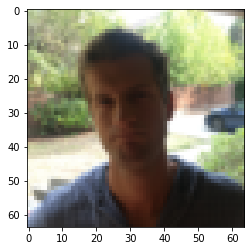

In [317]:
index = 10
imshow(X_train_norm[index, :, :, :])
label = train_y[0][index]
print(label, smile if label == 1 else 'not smile')

# 2 - Build a model in Keras

## 2-1 Model
```text
1. Initialize
- 定义输入shape
- X padding 处理

2. Conv Layer
- Convolution Computation
- BN
- Relu

3. Pooling Layer
- Max pool

4. Flatten
5. FC
6. sigmoid => Y_pred
```

In [318]:
def Model (img_size):
    # train_X 每次输入一个样本 (64 * 64 * 3)
    
    # 1-1 根据X.shape, 创建tensor
    # Tensor("input_1:0", shape=(None, 64, 64, 3), dtype=float32)
    X_input = Input(shape = img_size) # (64 * 64 * 3)
    
    # 1-2 Padding
    # (64 * 64 * 3) => 64 * 2 * padding => (70, 70, 3)
    X = ZeroPadding2D(padding = (3, 3))(X_input)
    
    # 2-1 Conv Layer
    """
      n_C = 32, f = 7, s = 1, p = 0
      n_C_prev = 3, n_W_prev = n_H_prev = 70
      n_H = n_W = ((70 - 7 + 0) / 1) + 1 = 64
      
      (m, n_H, n_W, n_C) = (m, 64, 64, 32)
    """
    Z = Conv2D(32, (7, 7), strides = (1, 1), padding = 'valid', name = 'CONV0')(X)
    # 2-2 BN
    Z = BatchNormalization(axis = 3, name = 'BN0')(Z)
    # 2-3 Relu
    A = Activation('relu')(Z)
    
    # 3-1 MAXPOOL
    # (m, 32, 32, 32)
    A_pool = MaxPooling2D((2, 2), name = 'MAXPOOL')(A)
    
    # 4-1 Flatten => softmax or sigmoid
    # 32 * 32 * 32 = 32768 neurons
    A_flatten = Flatten()(A_pool)
    # 4-2 FC => sigmoid
    Y_pred = Dense(units = 1, activation = 'sigmoid', name = 'FC')(A_flatten)
    
    # 5 Model (我们创建的function 名称有重合)
    model = keras.models.Model(inputs = X_input, outputs = Y_pred, name = 'Y_pred')
    
    return model

In [319]:
# 一个样本size
img_size = X_train_norm.shape[1:]
model = Model(img_size)

## 2-2 model compile

- binary_crossentropy 多用于二叉分类

In [320]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

## 2-3 training

In [321]:
model.fit(
    X_train_norm,
    Y_train,
    epochs=40,
    batch_size=50
)

Epoch 1/40
600/600 [==============================] - 2s 4ms/step - loss: 1.8969 - accuracy: 0.5650
Epoch 2/40
600/600 [==============================] - 2s 4ms/step - loss: 0.3585 - accuracy: 0.8400
Epoch 3/40
600/600 [==============================] - 2s 4ms/step - loss: 0.2007 - accuracy: 0.9300
Epoch 4/40
600/600 [==============================] - 2s 4ms/step - loss: 0.1581 - accuracy: 0.9417
Epoch 5/40
600/600 [==============================] - 2s 4ms/step - loss: 0.1253 - accuracy: 0.9533
Epoch 6/40
600/600 [==============================] - 2s 4ms/step - loss: 0.1268 - accuracy: 0.9467
Epoch 7/40
600/600 [==============================] - 2s 3ms/step - loss: 0.1080 - accuracy: 0.9650
Epoch 8/40
600/600 [==============================] - 2s 3ms/step - loss: 0.0970 - accuracy: 0.9750
Epoch 9/40
600/600 [==============================] - 2s 3ms/step - loss: 0.0687 - accuracy: 0.9800
Epoch 10/40
600/600 [==============================] - 2s 3ms/step - loss: 0.0624 - accuracy: 0.9800

## 2.4 Predict / Evaluate

In [322]:
test_predict = model.evaluate(
    X_test_norm, 
    Y_test, 
    batch_size=32, 
    verbose=1, 
    sample_weight=None
)

print('Cost:', str(test_predict[0]))
print('Test Accuracy:', str(test_predict[1]))

150/150 [==============================] - 0s 1ms/step
Cost: 0.20086335559686025
Test Accuracy: 0.8999999761581421


# 3 - Test my picture

In [323]:
def img (name):
    img_path = 'datasets/' + name + '.jpeg'
    print(img_path)
    
    # <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x1446DDC90>
    img = image.load_img(img_path, target_size = (64, 64))
    imshow(img)
    
    # 将图像转为矩阵, (64, 64, 3)
    img_matrix = image.img_to_array(img)
    # 代表一个样本 (1, 64, 64, 3)
    X = np.expand_dims(img_matrix, axis=0)
    # print(X.shape)
    
    X = preprocess_input(X)
    return X

datasets/smile.jpeg
[[1.]]


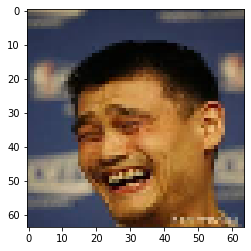

In [324]:
sample_smile = img('smile')
print(model.predict(sample_smile))

datasets/cry.jpeg
[[1.]]


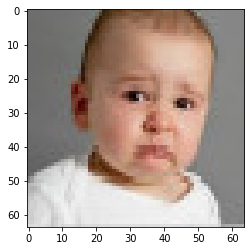

In [325]:
# 这个图片评估有问题
sample_cry = img('cry')
print(model.predict(sample_cry))

# 4 - Other useful functions in Keras

model.summary()
- prints the details of your layers in a table with the sizes of its inputs/outputs


plot_model()
- plots your graph in a nice layout. 
- You can even save it as ".png" using SVG() 
- if you'd like to share it on social media ;). It is saved in "File" then "Open..." in the upper bar of the notebook.

In [326]:
model.summary()

Model: "Y_pred"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_59 (ZeroPaddi (None, 70, 70, 3)         0         
_________________________________________________________________
CONV0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
BN0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_38 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
MAXPOOL (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 32768)             0    

In [328]:

plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.